##Meta-učení


V kontextu strojového učení se meta-učením rozumí použití metod ML ke zlepšení výsledků vlastního učení, tedy k vytvoření nebo nalezení lepších modelů. Jde tedy o učení se učit. 

Typicky se na základě předchozích zkušeností vybere, modifikuje nebo zkonstruuje nový algoritmus učení nebo model, který dosahuje lepších výsledků. 

Historicky se mezi přístupy meta-učení řadí klasické přístupy používané ve strojovém učení, jako je crossvalidace a ansámblové metody. 

Nově se za základní problémy meta-učení považuje výběr vhodného modelu k datům (problému) a hledání parametrů modelu pro daný problém. 

Meta-učení v teoretické oblasti reaguje na Větu o obědě zadarmo (No Free Lunch Theorem, NFL) vyústilo v návrhy nových teoretických přístupů jak meta-genetické programování a sebe-referenční učící stroje.

___NFL:___ "We show that all algorithms that search for an extremum of a cost function perform exactly the same, when averaged over all possible cost functions." (Wolpert et al, 1995, 1997)




###Příklad: hledání parametru modelu 

projdeme hodnoty parametru C u modelu SVM-stroje na datech iris. Crossvalidací ohodnotíme každý model.

1e-10
1.29154966501e-09
1.6681005372e-08
2.15443469003e-07
2.78255940221e-06
3.5938136638e-05
0.000464158883361
0.00599484250319
0.0774263682681
1.0


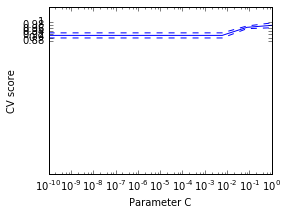

In [3]:
import numpy as np
from sklearn import cross_validation, datasets, svm

digits = datasets.load_iris()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    print (C)
    this_scores = cross_validation.cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

###Příklad: hledání parametru modelu pomocí GridSearch

projdeme hodnoty více parametrů u modelu SVM-stroje na datech digits.

In [4]:
from __future__ import print_function

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.987 (+/-0.018) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.030) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.018) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.027) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.018) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.018) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model 

###Příklad: Propojeni preprocessingu a učení s učitelem

pomocí pipeline propojíme PCA preprocessing a logistickou regresi, počet komponent u PCA určíme crossvalidovaným grid search


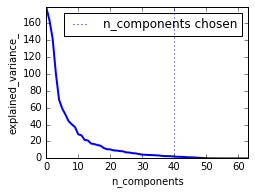

In [6]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

###############################################################################
# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()